In [1]:
# imports 
import re
import nltk
from datasets import load_dataset

import torch
import torch.nn as nn

from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!pip install rouge-score

  Preparing metadata (setup.py) ... - done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=8e506ae245796c2a0e95a3ac50cefc7ccc04eba8ba616cc0584169a06ea08ca9
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [3]:
# # loading the dataset
dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [5]:
#train and test splits
train_split = dataset['train'].select(range(28711)) 
test_split = dataset['test'].select(range(11490))

In [6]:
# data visualization of word frequency and sentence lengths
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize



# functions to calculate word frequencies and sentence lengths
def get_word_frequencies(texts):
    all_words = []
    for text in texts:
        words = word_tokenize(text.lower())  # Tokenize and lower case
        all_words.extend(words)
    word_freq = Counter(all_words)
    return word_freq

def get_sentence_lengths(texts):
    sentence_lengths = []
    for text in texts:
        sentences = sent_tokenize(text)  # Tokenize into sentences
        for sentence in sentences:
            sentence_lengths.append(len(word_tokenize(sentence)))  # Sentence length in terms of words
    return sentence_lengths

articles = train_split['article']
highlights = train_split['highlights']

# Word frequency distributions
article_word_freq = get_word_frequencies(articles)
highlight_word_freq = get_word_frequencies(highlights)


# Sentence length distributions
article_sentence_lengths = get_sentence_lengths(articles)
highlight_sentence_lengths = get_sentence_lengths(highlights)



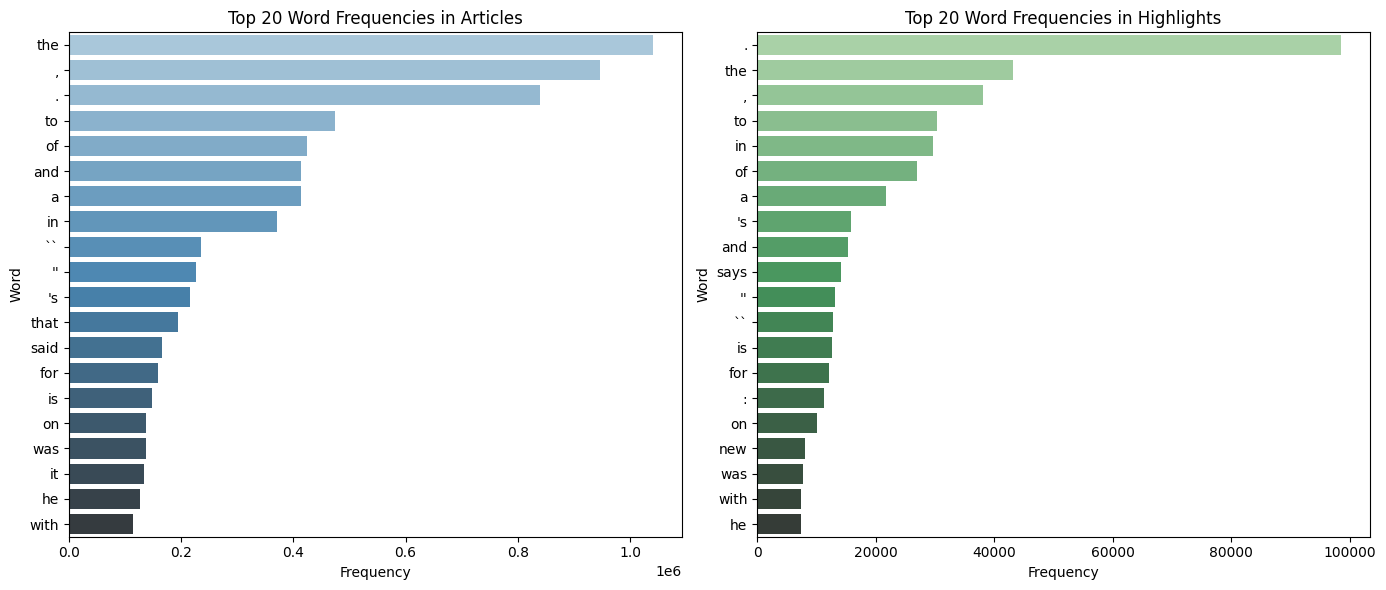

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


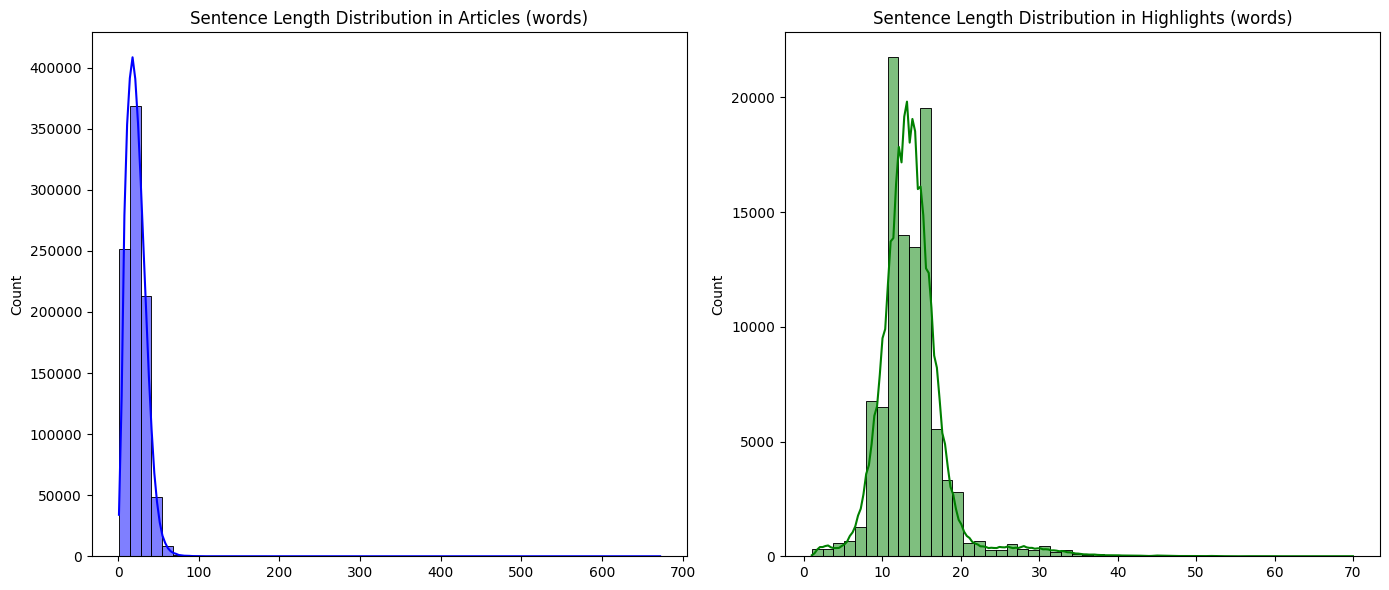

In [7]:
# displaying the data analysis
import pandas as pd


# Convert word frequency dictionaries to DataFrame for better plotting
article_word_freq_df = pd.DataFrame(article_word_freq.most_common(20), columns=['Word', 'Frequency'])
highlight_word_freq_df = pd.DataFrame(highlight_word_freq.most_common(20), columns=['Word', 'Frequency'])

# Plot word frequency distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Frequency', y='Word', data=article_word_freq_df, palette='Blues_d')
plt.title('Top 20 Word Frequencies in Articles')

plt.subplot(1, 2, 2)
sns.barplot(x='Frequency', y='Word', data=highlight_word_freq_df, palette='Greens_d')
plt.title('Top 20 Word Frequencies in Highlights')

plt.tight_layout()
plt.show()

# Plot sentence length distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(article_sentence_lengths, bins=50, kde=True, color='blue')
plt.title('Sentence Length Distribution in Articles (words)')

plt.subplot(1, 2, 2)
sns.histplot(highlight_sentence_lengths, bins=50, kde=True, color='green')
plt.title('Sentence Length Distribution in Highlights (words)')

plt.tight_layout()
plt.show()


In [8]:
def clean_text(text):
    # Lowercasing
    text = text.lower()
    
    # Removing special characters (retain only alphabets, numbers, and spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    
    # Tokenization using nltk's word_tokenize
    tokens = nltk.word_tokenize(text)
    
    # if length of tokens is greater than 500, truncate the tokens
    if len(tokens) > 768:
        tokens = tokens[:768]
    
    return tokens

# Apply the cleaning function to the dataset (cleaning the "article" and "highlights" columns)
train_cleaned = train_split.map(lambda x: {"cleaned_article": clean_text(x["article"]),
                                         "cleaned_highlights": clean_text(x["highlights"])},
                              remove_columns=["article", "highlights"])
test_cleaned = test_split.map(lambda x: {"cleaned_article": clean_text(x["article"]),
                                         "cleaned_highlights": clean_text(x["highlights"])},
                              remove_columns=["article", "highlights"])

# Display a few samples from the cleaned dataset
# print(cleaned_dataset['train'][0])

Map:   0%|          | 0/28711 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [9]:
train = train_cleaned
test = test_cleaned

In [10]:
SOS_token = 1
EOS_token = 2


# word dictionaries
word2index = {"<UNK>": 0,"<SOS>": 1,"<EOS>": 2,"<PAD>": 3}
word2count = {}
index2word = {0: "<UNK>",1: "<SOS>", 2: "<EOS>",3: "<PAD>"}
n_words = 4  # Count SOS and EOS

def addWord(word):
    global n_words
    if word not in word2index:
        word2index[word] = n_words
        word2count[word] = 1
        index2word[n_words] = word
        n_words += 1
    else:
        word2count[word] += 1

def addSentence(sentence):
    for word in sentence:
        addWord(word)


In [11]:
# if the word is not in the dictionary, return the index of the unknown token
def wordToIndex(word):
    return word2index.get(word, word2index['<UNK>'])

# if the index is not in the dictionary, return the index of the unknown token
def indexToWord(index):
    return index2word.get(index, '<UNK>')




In [12]:
max_article_length = 2134
max_highlight_length = 1230
article_length = max_article_length+3
highlights_length = max_highlight_length+3

# add SOS and EOS to the article and highlights
def add_padding(sentence, length):
    sentence.insert(0, "<SOS>")
    sentence.append("<EOS>")

    return sentence




In [13]:
# # add padding to the article and highlights
# for article in train['cleaned_article']:
#     article = add_padding(article, article_length)
#     addSentence(article)
    
# for highlights in cleaned_dataset['train']['cleaned_highlights']:
#     highlights = add_padding(highlights, highlights_length)
#     addSentence(highlights)
    

In [14]:
train.map(lambda x: addSentence(x['cleaned_article']))
train = train.map(lambda x: {"cleaned_article": add_padding(x["cleaned_article"], article_length),"cleaned_highlights": add_padding(x["cleaned_highlights"], highlights_length)})

test = test.map(lambda x: {"cleaned_article": add_padding(x["cleaned_article"], article_length),"cleaned_highlights": add_padding(x["cleaned_highlights"], highlights_length)})


Map:   0%|          | 0/28711 [00:00<?, ? examples/s]

Map:   0%|          | 0/28711 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [15]:
# convert the words to indexes
def wordsToIndexes(sentence):
    return [wordToIndex(word) for word in sentence]

train = train.map(lambda x: {"cleaned_article": wordsToIndexes(x["cleaned_article"]),"cleaned_highlights": wordsToIndexes(x["cleaned_highlights"])})
test = test.map(lambda x: {"cleaned_article": wordsToIndexes(x["cleaned_article"]),"cleaned_highlights": wordsToIndexes(x["cleaned_highlights"])})

Map:   0%|          | 0/28711 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [16]:
import torch

data_type = "torch"
format_columns = ["cleaned_article", "cleaned_highlights"]

# def convert_to_int16(batch):
#     return {col: torch.tensor(batch[col], dtype=torch.int16) for col in format_columns}

# train_data = train.map(convert_to_int16).with_format(
#     type=data_type, columns=format_columns, output_all_columns=True
# )
# test_data = test.map(convert_to_int16).with_format(
#     type=data_type, columns=format_columns, output_all_columns=True
# )

train_data = train.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)
test_data = test.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

In [17]:
## DataLoader

def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_articles = [item["cleaned_article"] for item in batch]
        batch_highlights = [item["cleaned_highlights"] for item in batch]
        batch_articles = nn.utils.rnn.pad_sequence(batch_articles, padding_value=pad_index)
        batch_highlights = nn.utils.rnn.pad_sequence(batch_highlights, padding_value=pad_index)
        batch = {"cleaned_article": batch_articles, "cleaned_highlights": batch_highlights}
        return batch
    return collate_fn

In [18]:
def get_data_loader(dataset, batch_size, pad_index,shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=shuffle)
    return data_loader

In [19]:
batch_size = 32
pad_index = word2index["<PAD>"]

train_data_loader = get_data_loader(train_data, batch_size, pad_index,shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)


## Seq2Seq Model Architecture

In [20]:
vocab_size = len(word2index)

In [21]:
## Encoder 
class Encoder(nn.Module):
    def __init__(self,input_dim,embedding_dim,hidden_dim,n_layers,dropout):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers    
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,src):
        embed = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embed)
        
        return outputs , hidden, cell


In [22]:
class Attention(nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
    def forward(self,decoder_hidden,encoder_outputs):
            
        encoder_outputs = encoder_outputs.permute(1,0,2)
            
        attention_scores = torch.bmm(encoder_outputs,decoder_hidden.unsqueeze(2)).squeeze(2)
            
        attention_weights  = torch.softmax(attention_scores, dim = 1)
            
        context = torch.bmm(attention_weights.unsqueeze(1),encoder_outputs).squeeze(1)
            
        return context, attention_weights

In [23]:
## Decoder
class Decoder(nn.Module):
    def __init__(self,output_dim,embedding_dim,hidden_dim,n_layers,dropout,attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,input,hidden,cell,encoder_outputs):
        input = input.unsqueeze(0)
        embed = self.dropout(self.embedding(input))

        output, (hidden, cell) = self.rnn(embed, (hidden, cell))
        
        
        context, attention_weights = self.attention(hidden[-1],encoder_outputs)

        
        # rnn_input = torch.cat((embed, context.unsqueeze(0)), dim = 2)   

        
        output = torch.cat((output.squeeze(0), context), dim = 1)

        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell

In [24]:
# Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder,device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self,src,trg,teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        encoder_outputs,hidden, cell = self.encoder(src)
        
        input = trg[0,:]

        
        for t in range(1, trg_len):
            # Pass the input, hidden, cell, and encoder outputs into the decoder
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[t] = output
            
            # Decide whether to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)  # Get the predicted word
            
            # If teacher forcing, use the actual next token as the next input
            # If not, use the predicted word
            input = trg[t] if teacher_force else top1
        
        return outputs

## Model Training


In [25]:
input_dim = vocab_size
output_dim = vocab_size
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.2
decoder_dropout = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(
    input_dim, 
    encoder_embedding_dim, 
    hidden_dim, 
    n_layers, 
    encoder_dropout
)

attention = Attention(hidden_dim)

decoder = Decoder(
    output_dim, 
    decoder_embedding_dim, 
    hidden_dim, 
    n_layers, 
    decoder_dropout,
    attention
)

model = Seq2Seq(encoder, decoder, device).to(device)


In [26]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(166578, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention()
    (embedding): Embedding(166578, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.2)
    (fc_out): Linear(in_features=1024, out_features=166578, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [27]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

Using 2 GPUs!


In [28]:
# initialize the weights of the model
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)


DataParallel(
  (module): Seq2Seq(
    (encoder): Encoder(
      (embedding): Embedding(166578, 256)
      (rnn): LSTM(256, 512, num_layers=2, dropout=0.2)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (decoder): Decoder(
      (attention): Attention()
      (embedding): Embedding(166578, 256)
      (rnn): LSTM(256, 512, num_layers=2, dropout=0.2)
      (fc_out): Linear(in_features=1024, out_features=166578, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
)

In [29]:
#optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = pad_index)


In [30]:
def train_fn(model,data_loader,optimizer,criterion,clip,teacher_forcing_ratio,device):
    model.train()
    epoch_loss = 0
    for i,batch in enumerate(data_loader):  
        src = batch["cleaned_article"].to(device)
        trg = batch["cleaned_highlights"].to(device)
        
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        
        trg = trg[1:].view(-1)

        output.detach()
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

        del src
        del trg
    return epoch_loss / len(data_loader)

In [31]:
## Evaluation
def evaluate_fn(model,data_loader,criterion,device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i ,batch in enumerate(data_loader):
            src = batch["cleaned_article"].to(device)
            trg = batch["cleaned_highlights"].to(device)
            
            output = model(src, trg, 0)
            
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)

            output.detach()
            
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()

            del src
            del trg
    return epoch_loss / len(data_loader)

In [32]:
# training the model
import tqdm
import random
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 1


best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(model, train_data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device)
    
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
 10%|█         | 1/10 [29:52<4:28:49, 1792.17s/it]

	Train Loss:   7.570 | Train PPL: 1938.630


 20%|██        | 2/10 [59:44<3:58:58, 1792.32s/it]

	Train Loss:   6.583 | Train PPL: 722.691


 30%|███       | 3/10 [1:29:39<3:29:15, 1793.71s/it]

	Train Loss:   6.010 | Train PPL: 407.472


 40%|████      | 4/10 [1:59:32<2:59:20, 1793.37s/it]

	Train Loss:   5.525 | Train PPL: 250.952


 50%|█████     | 5/10 [2:29:28<2:29:31, 1794.22s/it]

	Train Loss:   5.094 | Train PPL: 163.031


 60%|██████    | 6/10 [2:59:25<1:59:39, 1794.99s/it]

	Train Loss:   4.711 | Train PPL: 111.164


 70%|███████   | 7/10 [3:29:21<1:29:46, 1795.48s/it]

	Train Loss:   4.383 | Train PPL:  80.086


 80%|████████  | 8/10 [3:59:20<59:52, 1796.45s/it]  

	Train Loss:   4.103 | Train PPL:  60.528


 90%|█████████ | 9/10 [4:29:19<29:57, 1797.51s/it]

	Train Loss:   3.864 | Train PPL:  47.661


100%|██████████| 10/10 [4:59:24<00:00, 1796.40s/it]

	Train Loss:   3.650 | Train PPL:  38.493


In [33]:
model

DataParallel(
  (module): Seq2Seq(
    (encoder): Encoder(
      (embedding): Embedding(166578, 256)
      (rnn): LSTM(256, 512, num_layers=2, dropout=0.2)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (decoder): Decoder(
      (attention): Attention()
      (embedding): Embedding(166578, 256)
      (rnn): LSTM(256, 512, num_layers=2, dropout=0.2)
      (fc_out): Linear(in_features=1024, out_features=166578, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
)

In [34]:
# save the model 
torch.save(model.state_dict(), "model.pth")

In [35]:
# # clearing the model from memory
# del model

# import gc         # garbage collect library
# gc.collect()
# torch.cuda.empty_cache() 

In [36]:
# # load the model from model.pth and use it for inference
# model = Seq2Seq(encoder, decoder, device).to(device)
# model.load_state_dict(torch.load("model.pth"))

In [37]:
# ## Inference

# test_loss = evaluate_fn(model, test_data_loader, criterion, device)
# print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")



In [38]:
# generate the summary
def get_sum(sentence,model,device,max_len):
    model.eval()
    
    with torch.no_grad():
        src = torch.LongTensor(sentence).unsqueeze(-1).to(device)
        
        encoder_output,hidden, cell = model.module.encoder(src)
        
        trg_indexes = [word2index["<SOS>"]]
        
        for i in range(max_len):
            trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
            
            output, hidden, cell = model.module.decoder(trg_tensor, hidden, cell,encoder_output)

            output.detach()
            
            pred_token = output.argmax(-1).item()
            
            trg_indexes.append(pred_token)
            
            if pred_token == word2index["<EOS>"]:
                break
        
        trg_tokens = [index2word[int(i)] for i in trg_indexes]
        
        return trg_tokens
        
    

In [39]:
# get the summary of the first article in the test set
article = test[0]["cleaned_article"]
summary = get_sum(article, model, device, 50)

article = [indexToWord(i) for i in article]
print("Article:", article)

print("Predicted Summary:", summary)

# get the actual summary of the first article in the test set
actual_summary = test[0]["cleaned_highlights"]
actual_summary = [indexToWord(i) for i in actual_summary]

print("Actual Summary:", actual_summary)


Article: ['<SOS>', '<UNK>', 'palestinian', 'authority', 'officially', 'became', 'the', '123rd', 'member', 'of', 'the', 'international', 'criminal', 'court', 'on', 'wednesday', 'a', 'step', 'that', 'gives', 'the', 'court', 'jurisdiction', 'over', 'alleged', 'crimes', 'in', 'palestinian', 'territories', 'the', 'formal', 'accession', 'was', 'marked', 'with', 'a', 'ceremony', 'at', 'the', 'hague', 'in', 'the', 'netherlands', 'where', 'the', 'court', 'is', 'based', 'the', 'palestinians', 'signed', 'the', 'iccs', 'founding', 'rome', 'statute', 'in', 'january', 'when', 'they', 'also', 'accepted', 'its', 'jurisdiction', 'over', 'alleged', 'crimes', 'committed', 'in', 'the', 'occupied', 'palestinian', 'territory', 'including', 'east', 'jerusalem', 'since', 'june', '13', '2014', 'later', 'that', 'month', 'the', 'icc', 'opened', 'a', 'preliminary', 'examination', 'into', 'the', 'situation', 'in', 'palestinian', 'territories', 'paving', 'the', 'way', 'for', 'possible', 'war', 'crimes', 'investigat

In [40]:
# get the summary of the second article in the test set
article = test[1]["cleaned_article"]
summary = get_sum(article, model, device, 50)

print("Summary:", summary)

# get the actual summary of the first article in the test set
actual_summary = test[1]["cleaned_highlights"]
actual_summary = [indexToWord(i) for i in actual_summary]

print("Actual Summary:", actual_summary)


Summary: ['<SOS>', 'the', '2100', 'research', 'of', 'the', 'southern', 'california', 'exhibit', 'is', 'a', 'fiveminute', 'of', 'the', 'city', 'the', 'painting', 'is', 'valued', 'at', 'the', 'root', 'of', 'the', 'worlds', 'largest', 'supersonic', 'restaurant', 'the', 'company', 'says', 'it', 'is', 'a', 'great', 'location', 'of', 'the', 'arctic', 'mining', 'center', '<EOS>']
Actual Summary: ['<SOS>', '<UNK>', 'a', 'bully', 'breed', 'mix', 'was', 'apparently', 'hit', 'by', 'a', 'car', 'whacked', 'with', 'a', 'hammer', 'and', 'buried', 'in', 'a', 'field', 'shes', 'a', 'true', 'miracle', 'dog', 'and', 'she', 'deserves', 'a', 'good', 'life', 'says', 'sara', 'mellado', 'who', 'is', 'looking', 'for', 'a', 'home', 'for', '<UNK>', '<EOS>']


In [41]:
# compute rouge2 and rougeL scores for the test set
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge2', 'rougeL'], use_stemmer=True)

rouge2_scores = []
rougeL_scores = []

for i in range(len(test)):
    article = test[i]["cleaned_article"]
    summary = get_sum(article, model, device, 50)
    
    actual_summary = test[i]["cleaned_highlights"]
    actual_summary = [indexToWord(i) for i in actual_summary]
    
    scores = scorer.score(" ".join(summary), " ".join(actual_summary))
    rouge2_scores.append(scores["rouge2"].fmeasure)
    rougeL_scores.append(scores["rougeL"].fmeasure)
    
rouge2_score = np.mean(rouge2_scores)
rougeL_score = np.mean(rougeL_scores)

print(f"ROUGE-2 Score: {rouge2_score:.5f}")
print(f"ROUGE-L Score: {rougeL_score:.5f}")


ROUGE-2 Score: 0.01427
ROUGE-L Score: 0.14807


In [42]:
# # save the model 
# torch.save(model.state_dict(), "model.pth")
# del model

# import gc         # garbage collect library
# gc.collect()
# torch.cuda.empty_cache() 

In [43]:
# # load the model from model.pth and use it for inference
# model = Seq2Seq(encoder, decoder, device).to(device)
# model.load_state_dict(torch.load("model.pth"))

In [44]:
# load the dataset jordiclive/wikipedia-summary-dataset for testing
dataset = load_dataset("jordiclive/wikipedia-summary-dataset")


README.md:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


df_withDescription.parquet:   0%|          | 0.00/8.65G [00:00<?, ?B/s]

df_withoutDescription.parquet:   0%|          | 0.00/6.77G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [45]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'description', 'summary', 'full_text', '__index_level_0__'],
        num_rows: 7750007
    })
})

In [46]:
# use only the first 10k rows for testing
test = dataset['train'].select(range(10000))

# preprocess the dataset to use the same format as the CNN/DailyMail dataset
test = test.map(lambda x: {"cleaned_article": clean_text(x["full_text"]),
                             "cleaned_highlights": clean_text(x["summary"])},
                  remove_columns=["full_text", "summary"])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [47]:
test = test.map(lambda x: {"cleaned_article": add_padding(x["cleaned_article"], article_length),"cleaned_highlights": add_padding(x["cleaned_highlights"], highlights_length)})
test = test.map(lambda x: {"cleaned_article": wordsToIndexes(x["cleaned_article"]),"cleaned_highlights": wordsToIndexes(x["cleaned_highlights"])})

test_set = test.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [48]:

# # test this model on the wikipedia dataset
# test_data_loader = get_data_loader(test_set, batch_size, pad_index, shuffle=False)
# test_loss = evaluate_fn(model, test_data_loader, criterion, device)
# print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

In [49]:
# compute rouge2 and rougeL scores for the test set
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge2', 'rougeL'], use_stemmer=True)

rouge2_scores = []
rougeL_scores = []

for i in range(len(test_set)):
    article = test_set[i]["cleaned_article"]
    summary = get_sum(article, model, device, 50)
    
    actual_summary = test_set[i]["cleaned_highlights"]
    actual_summary = [indexToWord(int(i)) for i in actual_summary]
    
    scores = scorer.score(" ".join(summary), " ".join(actual_summary))
    rouge2_scores.append(scores["rouge2"].fmeasure)
    rougeL_scores.append(scores["rougeL"].fmeasure)
    
rouge2_score = np.mean(rouge2_scores)
rougeL_score = np.mean(rougeL_scores)

print(f"ROUGE-2 Score: {rouge2_score:.5f}")
print(f"ROUGE-L Score: {rougeL_score:.5f}")


ROUGE-2 Score: 0.02094
ROUGE-L Score: 0.12217


In [50]:
# get the summary of the first article in the test set
article = test_set[0]["cleaned_article"]
summary = get_sum(article, model, device, 50)

article = [indexToWord(int(i)) for i in article]
print("Article:", article)

print("Predicted Summary:", summary)

# get the actual summary of the first article in the test set
actual_summary = test_set[0]["cleaned_highlights"]
actual_summary = [indexToWord(int(i)) for i in actual_summary]

print("Actual Summary:", actual_summary)


Article: ['<SOS>', 'animalia', 'is', 'an', 'illustrated', 'childrens', 'book', 'by', 'graeme', 'base', 'it', 'was', 'originally', 'published', 'in', '1986', 'followed', 'by', 'a', 'tenth', 'anniversary', 'edition', 'in', '1996', 'and', 'a', '25th', 'anniversary', 'edition', 'in', '2012', 'over', 'four', 'million', 'copies', 'have', 'been', 'sold', 'worldwide', 'a', 'special', 'numbered', 'and', 'signed', 'anniversary', 'edition', 'was', 'also', 'published', 'in', '1996', 'with', 'an', 'embossed', 'gold', 'jacket', 'synopsis', 'animalia', 'is', 'an', 'alliterative', 'alphabet', 'book', 'and', 'contains', 'twentysix', 'illustrations', 'one', 'for', 'each', 'letter', 'of', 'the', 'alphabet', 'each', 'illustration', 'features', 'an', 'animal', 'from', 'the', 'animal', 'kingdom', 'a', 'is', 'for', 'alligator', 'and', '<UNK>', 'b', 'is', 'for', 'butterfly', 'etc', 'along', 'with', 'a', 'short', 'poem', 'utilizing', 'the', 'letter', 'of', 'the', 'page', 'for', 'many', 'of', 'the', 'words', 't